# Imports

In [1]:
import pandas as pd
import utils
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Color Codes

In [2]:
conjunction_colors = {
    "and": "#be0aff",
    "or": "#580aff",
    "but": "#0043ce",
    "nor": "#d12c19"
}

like_unlike_colors = {
    "likes": "#008bf8",
    "unlikes": "#dc0073"
}

category_colors = {
    "NP": "#ee1266",
    "VP": "#6a4c93",
    "ADJP": "#1982c4",
    "ADVP": "#0ead69",
    "PP": "#ff4b35",
    "SBAR": "#00cecb"
}

# COCA Analysis
(We might skip this for now)

In [3]:
# Conjunctions under analysis
CONJUNCTIONS = ['and', 'or', 'but', 'nor']

# Categories under analysis
NOUN_CATEGORIES = ['NN', 'NNS', 'NNP', 'NNPS', 'NP', 'NX']
VERB_CATEGORIES = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'VP']
ADJ_CATEGORIES = ['JJ', 'JJR', 'JJS', 'ADJP']
ADV_CATEGORIES = ['RB', 'RBR', 'RBS', 'ADVP']

PHRASAL_CATEGORIES = ['NP', 'VP', 'ADJP', 'ADVP']

In [4]:
# Load CSV file with coordination samples
samples = pd.read_csv("csv/COCA/samples.csv", index_col=None, header=0)

# Load CSV files with raters' judgments
rater1 = pd.read_csv("csv/COCA/raters/rater1.csv", index_col=None, header=0)
rater2 = pd.read_csv("csv/COCA/raters/rater2.csv", index_col=None, header=0)
rater3 = pd.read_csv("csv/COCA/raters/rater3.csv", index_col=None, header=0)

# Take majority of three raters' judgments
r1 = rater1['Correct?']
r2 = rater2['Correct?']
r3 = rater3['Correct?']
samples['Correct? (Majority)'] = r1 & r2 & r3
correct = samples[samples['Correct? (Majority)']]
correct.to_csv('csv/COCA/correct_samples.csv')

In [5]:
# likes = utils.likes_df(correct)
# unlikes = utils.unlikes_df(correct)

# likes = utils.filter_conj_length(likes, 5)
# unlikes = utils.filter_conj_length(unlikes, 5)

In [6]:
# utils.add_conj_heads(likes)
# utils.add_conj_heads(unlikes)

In [7]:
# likes

# PTB

In [8]:
# Load samples from PTB
ptb_samples = pd.read_csv("csv/PTB/PTB_ccps.csv", index_col=None, header=0)

# Get like coordinations
ptb_likes = utils.likes_df(ptb_samples)

# Filter coordinations so that each conjunct is only one word
ptb_likes = utils.filter_conj_length(ptb_likes, 1)

# Add conjunct heads
# ptb_likes = utils.add_conj_heads(ptb_likes)

In [9]:
# Add conjunct head columns for wordnet analysis
# We can do this since each conjunct is only one word long
ptb_likes['1st Conjunct Head'] = ptb_likes['1st Conjunct Text']
ptb_likes['2nd Conjunct Head'] = ptb_likes['2nd Conjunct Text']

# Finding closures over wordnet relations produces redundant search warnings
# We'll just filter these warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Get wordnet relations for like coordinations from PTB
    ptb_synonymy_df = utils.analyze_synonymy(ptb_likes)
    ptb_antonymy_df = utils.analyze_antonymy(ptb_likes)
    ptb_hypernymy_df = utils.analyze_hypernymy(ptb_likes)
    ptb_cohyponymy_df = utils.analyze_cohyponymy(ptb_likes)
    ptb_entailment_df = utils.analyze_entailment(ptb_likes)

ptb_synonyms = ptb_synonymy_df[ptb_synonymy_df['Synonyms?'] == True]
utils.pretty_print(ptb_synonyms, 'rtf/ptb_synonyms.rtf')

# Synonyms

In [10]:
def get_synonyms_freqs(df):
    # Get synonyms
    syns = df.loc[(df['Synonyms?'] == True)]

    # Get counts
    syns_count = len(syns)
    tot = len(df)

    print('syns:', syns_count)
    print('not syns:', tot - syns_count)

    return syns_count / tot

### By conjunction

In [11]:
def synonym_conjunction_distribution(synonyms_df, source, outfile):

    labels = []
    syns_freqs = []

    for conjunction in CONJUNCTIONS:
        print(conjunction)

        labels.append(conjunction)

        df = synonyms_df.copy()
        df = df.loc[df['Conjunction'] == conjunction]

        if df is None:
            continue

        syns_freqs.append(get_synonyms_freqs(df))

    x = np.arange(len(labels))  # the label locations
    width = 0.6  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, syns_freqs, width, color=conjunction_colors.values())

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    ax.set_title(
        'Percentages of Coordinations with Synonymy\nby Conjunction (' + source + ')')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha='center', va='bottom', color='white')

    plt.savefig(outfile, bbox_inches='tight')


and
syns: 54
not syns: 3485
or
syns: 7
not syns: 455
but
syns: 0
not syns: 35
nor
syns: 0
not syns: 12


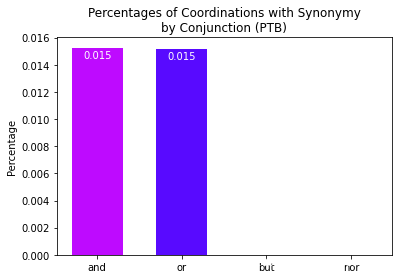

In [12]:
synonym_conjunction_distribution(ptb_synonymy_df, 'PTB', 'charts/PTB_synonymy_by_conjunction.pdf')

### By category

In [13]:
def synonym_category_distribution(synonyms_df, source, outfile):
    labels = []
    syns_freqs = []


    print('Nominal')
    labels.append('Nominal')

    # Concatenate all CSVs for the specified genre into one dataframe
    df = synonyms_df.copy()
    df = df.loc[df['1st Conjunct Category'].isin(NOUN_CATEGORIES)]
    df = df.loc[df['2nd Conjunct Category'].isin(NOUN_CATEGORIES)]
    syns_freqs.append(get_synonyms_freqs(df))


    print('Verbal')
    labels.append('Verbal')

    df = synonyms_df.copy()
    df = df.loc[df['1st Conjunct Category'].isin(VERB_CATEGORIES)]
    df = df.loc[df['2nd Conjunct Category'].isin(VERB_CATEGORIES)]
    syns_freqs.append(get_synonyms_freqs(df))

    print('Adjectival')
    labels.append('Adjectival')

    df = synonyms_df.copy()
    df = df.loc[df['1st Conjunct Category'].isin(ADJ_CATEGORIES)]
    df = df.loc[df['2nd Conjunct Category'].isin(ADJ_CATEGORIES)]
    syns_freqs.append(get_synonyms_freqs(df))

    print('Adverbial')
    labels.append('Adverbial')

    df = synonyms_df.copy()
    df = df.loc[df['1st Conjunct Category'].isin(ADV_CATEGORIES)]
    df = df.loc[df['2nd Conjunct Category'].isin(ADV_CATEGORIES)]
    syns_freqs.append(get_synonyms_freqs(df))

    x = np.arange(len(labels))  # the label locations
    width = 0.6  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, syns_freqs, width, color=category_colors.values())

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    ax.set_title('Percentages of Coordinations with Synonymy\nby Syntactic Category (' + source + ')')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha='center', va='bottom', color='white')

    plt.savefig(outfile, bbox_inches='tight')

Nominal
syns: 47
not syns: 2858
Verbal
syns: 11
not syns: 446
Adjectival
syns: 1
not syns: 598
Adverbial
syns: 2
not syns: 98


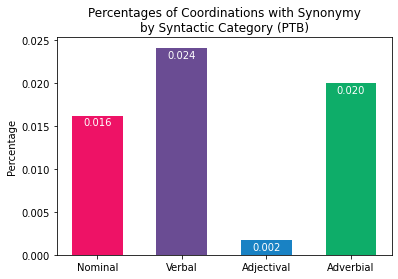

In [14]:
synonym_category_distribution(ptb_synonymy_df, 'PTB', 'charts/PTB_synonymy_by_category.pdf')